Afisarea modelelor codificate de filtre

Vom arunca o privirea la reteaua VG16 si vom folosi ascensiunea  gradient in spatiul de intrare.

Acest lucru inseamna ca, incepend cu o imagine goala, aplicam  gradient descent la valoarea acestei imagini  de intrare a unui convnet, astfel incat sa maximizam raspunul unui filtru specific.

https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.4-visualizing-what-convnets-learn.ipynb

In [6]:
from keras.applications import VGG16
from keras import backend as K
import  numpy as np
import matplotlib.pyplot as plt

model = VGG16(weights='imagenet', include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

#Calling gradeints returneaza o lista de tensori de dimensiuni 1
#Prin urmare pastram primul element
grads = K.gradients(loss, model.input)[0]

#Suntem la 0.00001 sa ne asiguram ca nu impartim cu 0
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

iterate = K.function([model.input], [loss, grads])

loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

#Incepem cu o imagine gri goala cu ceva noise
input_img_data = np.random.random((1,150,150,3))*20 +128.

#marimea fiecarui pas de gradient
step = 1

#Vom rula pentru 40 de pasi
for i in range(40):
    #Caluleaza pierderea si valoarea gradient
    loss_value, grads_value = iterate([input_img_data])

    #Regleaza imaginea de intrare in directia care maximizeaza pierderea
    input_img_data += grads_value * step


In [7]:
#Functia Helper care trasforma un tensor int-o imagine
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x 


 O functie care generaza o vizualizarile filtrelor

In [8]:
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads)))+ 1e-5)
    iterate = K.function([model.input],[loss, grads])
    input_img_data = np.random.random((1, size, size, 3))* 20 +128

    step = 1

    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        img = input_img_data[0]
    return deprocess_image(img)

In cele din urma, trasarea modelului de filtru la care respunde maxim canalul zeroth din stratul block3_conv1

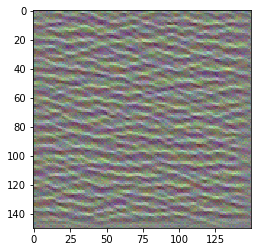

In [11]:
plt.imshow(generate_pattern('block3_conv1', 1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


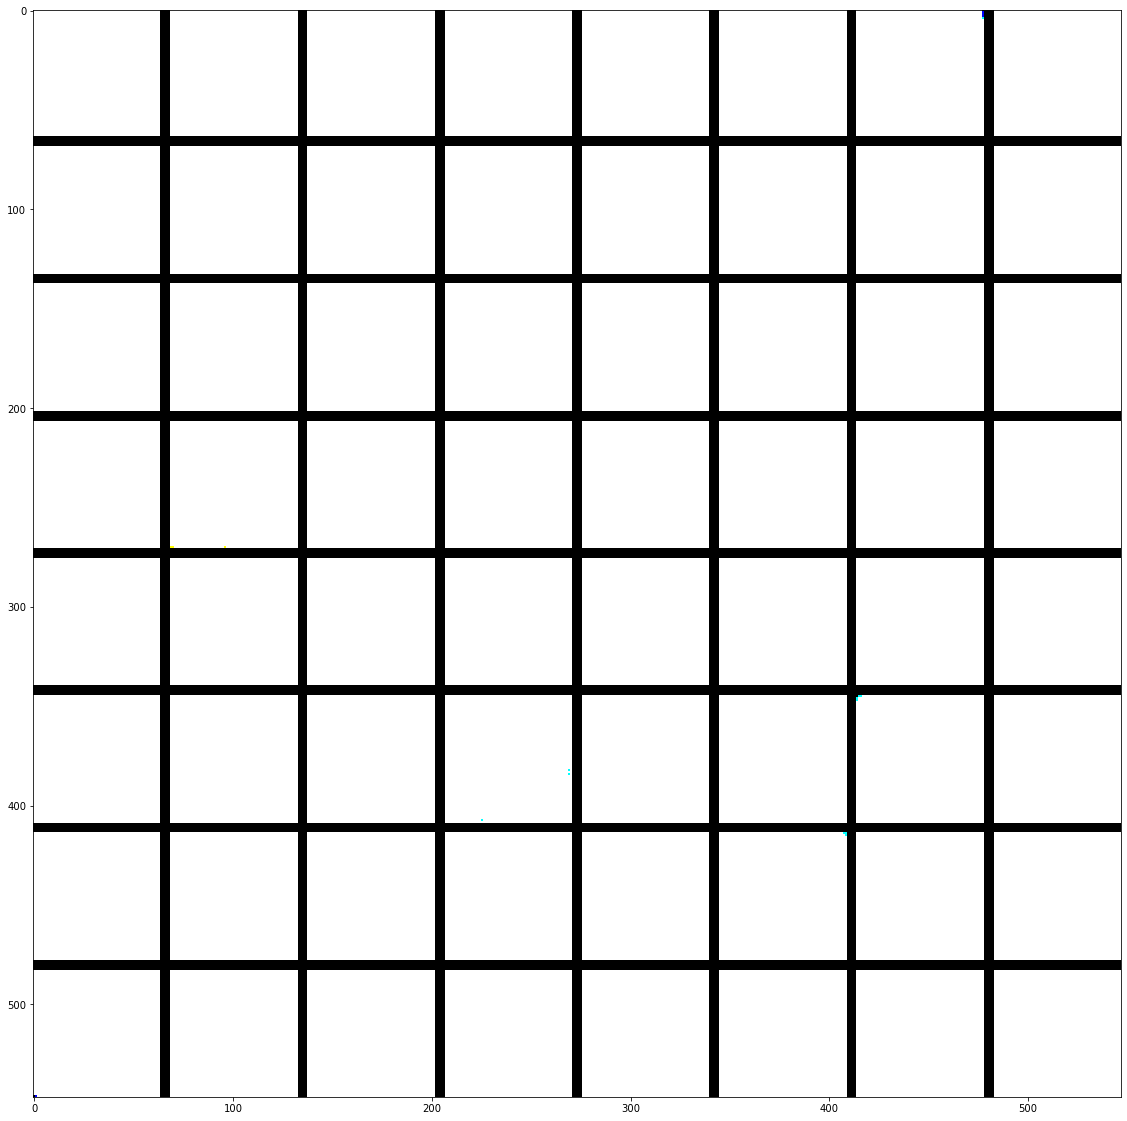

In [12]:
layer_name = 'block1_conv1'
size = 64
margin = 5

results = np.zeros((8*size + 7* margin, 8 * size +7 *margin, 3))

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i+(j*8), size=size, )
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size +j * margin
        vertical_end = vertical_start +size
        results[horizontal_start:horizontal_end, vertical_start:vertical_end, :]= filter_img

plt.figure(figsize=(20,20))
plt.imshow(results)